# Entropic estimation of optimal transport maps

In this tutorial, we show some of the visual and statistical aspects of the entropic estimator of transport map presented in {cite}`pooladian:21`. To do so, we will use its implementation at {class}`problems.linear.potentials.EntropicPotentials.transport`.

## Mathematical Formalism

{cite}`pooladian:21` introduces the **barycentric projection on the optimal entropic plan** as an estimator of the optimal transport map.

Formally, for $P$ a source distribution and $Q$ a target distribution, with $T_0$ the optimal transport map between these two distributions. We define $\pi_\epsilon$ the optimal entropic plan between $P$ and $Q$, and $(f_\epsilon, g_\epsilon)$ the optimal entropic potentials. The barycentric projection is defined as 
$ T_\epsilon =  \int y d\pi_\epsilon^x(y) = \mathbb{E}_{\pi_\epsilon}[Y | X = x]$. 

Where $d\pi_\epsilon^x(\cdot) = e^{(f_\epsilon(x) + g_\epsilon(\cdot) - ||x-\cdot||^2)/ϵ} dQ$

In some cases, such as the two sample case where both source and target are histograms, we can get a closed form, computable in $O(n)$ time given that we have the training samples evaluations of $g_\epsilon$. 

However, in `proposition 2` of {cite}`pooladian:21`, it is proven that in the general case, it is equivalent to the following quantity : $T_\epsilon = (Id − ∇f_\epsilon)$. 

This is what **OTT** does as it computes the optimal entropic potentials using the sinkhorn solver and use the latter formulation to build the estimator.

## Setting up

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.2/142.2 kB 12.0 MB/s eta 0:00:00


In [17]:
from typing import Callable

import jax
import jax.numpy as jnp
import numpy as np
from sklearn import datasets

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

## Two-samples estimates

We consider the case where we are given two samples set from different distribution (opposed as the case where none or only one is samples).

In order to know the optimal transport maps and be able to compute errors, we fix the source distribution so that $P = \text{Uniform}([-1, 1]^d)$. 

Therefore for any function $f : [-1, 1]^d → \mathbb{R}^{d'}$, and $X_n \sim P$, $Y_n := f(X_n) \sim Q$ with  $dQ = f dλ$

This ensures that we obtain valid erros


In [18]:
rng = jax.random.PRNGKey(0)
rng, *rngs = jax.random.split(rng, 5)

In [19]:
def get_estimated_transport_map(
    x: jax.Array, y: jax.Array, epsilon: float
) -> Callable:
    geom = pointcloud.PointCloud(x=x, y=y, epsilon=epsilon)
    solver_output = sinkhorn.solve(geom)

    if isinstance(solver_output, sinkhorn.SinkhornOutput):
        # Always verified as sinkhorn.solve rank argument is defaulted to -1
        # it is only to avoid trigerring linters
        return solver_output.to_dual_potentials().transport

    else:
        raise ValueError("...")

### 2-dimensional case

We visualize the outputs of our estimator implementation in 2 dimensions, for a uniform source distribution and two simple explicit transports.

For the first example, we take $T_0 : x \in [-1, 1]^d → e^x$

In [20]:
n, dim = 1000, 2
x = jax.random.uniform(rngs[0], (n, dim), minval=-1, maxval=1)
y = jnp.exp(x)

m = 1000
x_ = jax.random.uniform(rngs[1], (m, dim), minval=-1, maxval=1)
y_ = jnp.exp(x_)

estimated_map = get_estimated_transport_map(x, y, 0.05)
y_hat = estimated_map(x_)

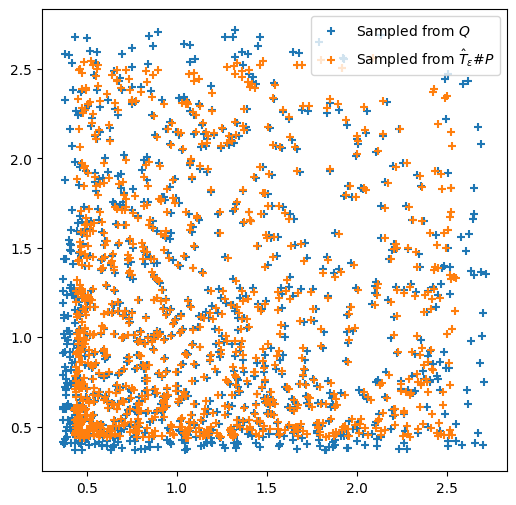

In [21]:
plt.figure(figsize=(6, 6))
plt.scatter(y_[:, 0], y_[:, 1], marker="+", label="Sampled from $Q$")
plt.scatter(
    y_hat[:, 0],
    y_hat[:, 1],
    marker="+",
    label=r"Sampled from $\hat{T}_\epsilon\# P$",
)
plt.legend()
plt.show()

For the second example, we take $T_0 : x \in [-1, 1]^d → 3x^2 \cdot \text{sgn}(x)$

In [22]:
n, dim = 1000, 2
x = jax.random.uniform(rngs[2], (n, dim), minval=-1, maxval=1)
y = 3 * x**2 * jnp.sign(x)

m = 1000
x_ = jax.random.uniform(rngs[3], (m, dim), minval=-1, maxval=1)
y_ = 3 * x_**2 * jnp.sign(x_)
estimated_map = get_estimated_transport_map(x, y, 0.05)
y_hat = estimated_map(x_)

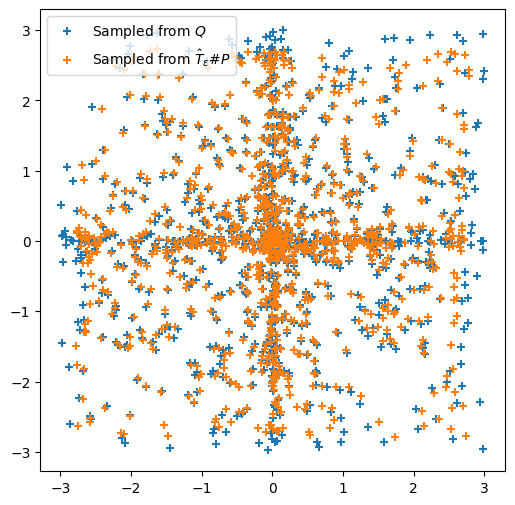

In [23]:
plt.figure(figsize=(6, 6))
plt.scatter(y_[:, 0], y_[:, 1], marker="+", label="Sampled from $Q$")
plt.scatter(
    y_hat[:, 0],
    y_hat[:, 1],
    marker="+",
    label=r"Sampled from $\hat{T}_\epsilon\# P$",
)
plt.legend()
plt.show()

## MSE according to the number of samples

We show the MSE error (Monte Carlo estimation) made by the estimator for different numbers of samples and different dimensions.

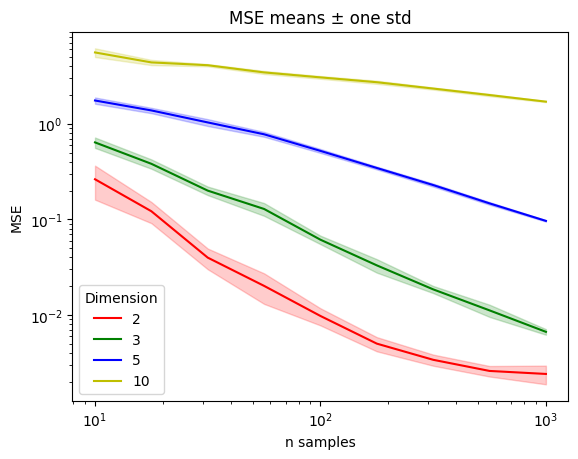

In [24]:
M = 10  # number of MC iterations
m = 2000  # number of samples in MSE estimation
dims = [2, 3, 5, 10]
colors = ["r", "g", "b", "y", "m", "c", "k", "w"]
n_samples = np.logspace(1, 3, 9)
eps = 0.05


for dim, color in zip(dims, colors):
    errors = np.zeros((M, 9))
    for i in range(M):
        for j, n in enumerate(n_samples):
            rng = jax.random.PRNGKey(i)
            n = int(n)
            x = jax.random.uniform(rng, (n, dim), minval=-1, maxval=1)
            y = jnp.exp(x)
            x_ = jax.random.uniform(rng, (m, dim), minval=-1, maxval=1)
            y_ = jnp.exp(x_)
            estimated_map = get_estimated_transport_map(x, y, 0.05)
            y_hat = estimated_map(x_)
            errors[i, j] = (jnp.linalg.norm(y_ - y_hat) ** 2 / m).item()
    plt.plot(n_samples, np.mean(errors, axis=0), label=dim, color=color)
    plt.fill_between(
        n_samples,
        np.mean(errors, axis=0) - np.std(errors, axis=0),
        np.mean(errors, axis=0) + np.std(errors, axis=0),
        alpha=0.2,
        color=color,
    )


plt.xlabel
plt.xscale("log")
plt.yscale("log")
plt.xlabel("n samples")
plt.ylabel("MSE")
plt.legend(title="Dimension")
plt.title("MSE means ± one std")
plt.show()

## MSE as a function of epsilon

We show the MSE error (Monte Carlo estimation) made by the estimator for different values of $\epsilon$, for $n=1000$ and $d=10$. 

We consider $T_0 : x → e^x$.

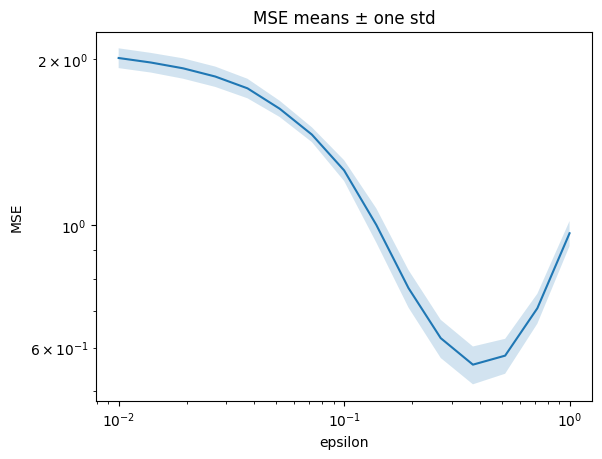

In [25]:
M = 10  # number of MC iterations
m = 100  # number of samples in MSE estimation
dim = 10
n = 1000
epsilons = np.logspace(-2, 0, 15)
errors = np.zeros((M, 15))

for j, eps in enumerate(epsilons):
    for i in range(M):
        rng = jax.random.PRNGKey(i)
        n = int(n)
        x = jax.random.uniform(rng, (n, dim), minval=-1, maxval=1)
        y = jnp.exp(x)
        x_ = jax.random.uniform(rng, (m, dim), minval=-1, maxval=1)
        y_ = jnp.exp(x_)
        estimated_map = get_estimated_transport_map(x, y, eps)
        y_hat = estimated_map(x_)
        errors[i, j] = (jnp.linalg.norm(y_ - y_hat) ** 2 / m).item()
plt.plot(epsilons, np.mean(errors, axis=0))
plt.fill_between(
    epsilons,
    np.mean(errors, axis=0) - np.std(errors, axis=0),
    np.mean(errors, axis=0) + np.std(errors, axis=0),
    alpha=0.2,
)


plt.xlabel
plt.xscale("log")
plt.yscale("log")
plt.xlabel("epsilon")
plt.ylabel("MSE")
plt.title("MSE means ± one std")
plt.show()

# Benchmark on some common benchmark datasets

The difficulties for benchmarking Optimal Transport Map comes from the fact that the exact solution is not known except for synthetic data. 
In the following lines, we are going to give visual examples of the matching obtained using the estimated transport map.

We first build a normal sample generator, which will be our source.

In [26]:
def gaussian_generator(n_samples: int, noise: float, key: int) -> jax.Array:
    assert noise < 1.0, "The noise is larger than source distribution"
    return (
        jax.random.normal(key=key, shape=(n_samples, 2))
        + jax.random.normal(key=key, shape=(n_samples, 2)) * noise
    )

Then we add generator of synthetic data that accepts the usual synthetic data generators of scikit-learn and ours.

In [27]:
class SyntheticDataGenerator:
    def __init__(
        self,
        sklearn_generator: Callable = gaussian_generator,
        noise: float = 0.1,
        seed: int = 1,
        scale: float = 1,
        loc: jax.Array = jnp.array([0, 0]),
    ):
        self.sklearn_generator = sklearn_generator
        self.noise = noise
        self.key_gen = jax.random.PRNGKey(seed)
        self.scale = scale
        self.loc = loc

    def __get_samples(self, n_samples: int = 100) -> np.ndarray:
        self.key_gen, key_ = jax.random.split(self.key_gen)
        try:
            X = self.sklearn_generator(n_samples, noise=self.noise, key=key_)
        except TypeError:
            X, _ = self.sklearn_generator(
                n_samples, noise=self.noise, random_state=key_.tolist()[0]
            )
            X = X[:, [0, 2]]

        return self.loc + self.scale * X

    def __call__(self, n_samples: int = 100):
        return self.__get_samples(n_samples)

We will look at different target distribution : the S one and the swiss roll one.
We adapted the scale in order to have expressive plots later on.

In [28]:
gaussian_gen = SyntheticDataGenerator(scale=0.8)
s_gen = SyntheticDataGenerator(datasets.make_s_curve, scale=2)
swiss_gen = SyntheticDataGenerator(datasets.make_swiss_roll, scale=1.0)

In [29]:
X = gaussian_gen(500)
Y_1 = s_gen(500)
Y_2 = swiss_gen(500)

We compute the transportation maps using our estimator.

In [30]:
s_curve_map = get_estimated_transport_map(X, Y_1, epsilon=0.075)
swiss_roll_map = get_estimated_transport_map(X, Y_2, epsilon=0.075)

And plot them, displaying the matching between the source and the transported source.

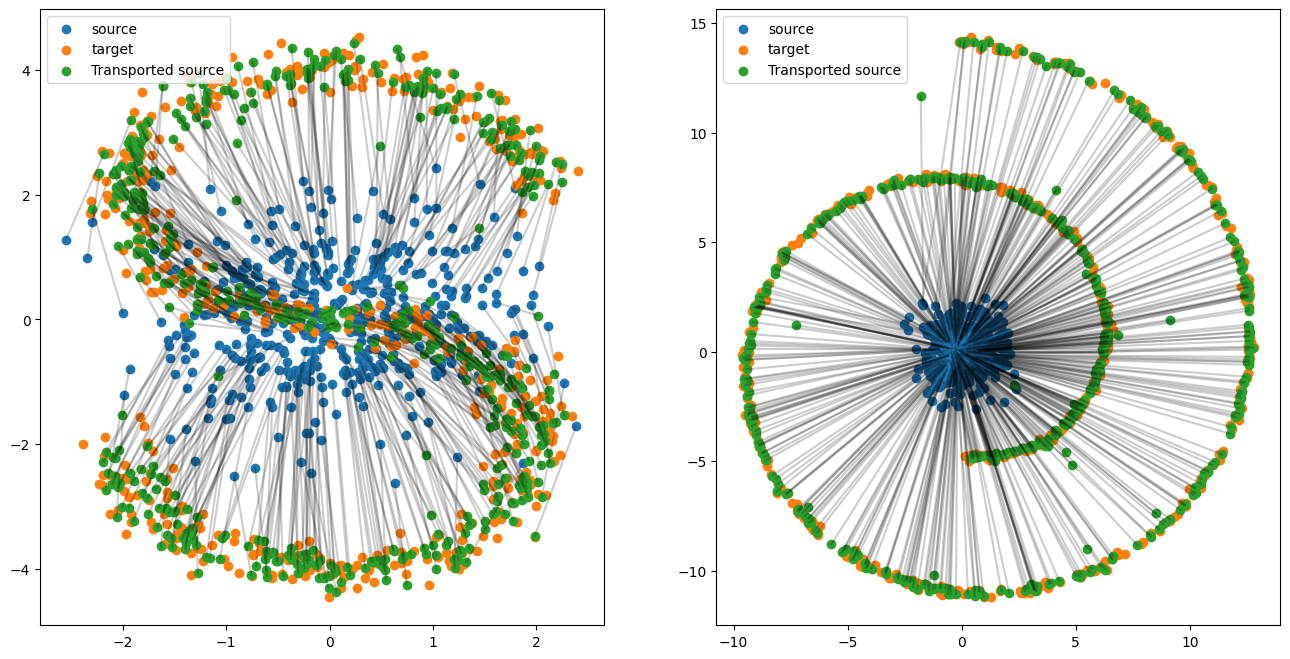

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

Y_1_transported = s_curve_map(X)

ax1.scatter(X[:, 0], X[:, 1], label="source")
ax1.scatter(Y_1[:, 0], Y_1[:, 1], label="target")
ax1.scatter(
    Y_1_transported[:, 0], Y_1_transported[:, 1], label="Transported source"
)
ax1.legend()


for p1, p2 in zip(X, Y_1_transported):
    ax1.plot([p1[0], p2[0]], [p1[1], p2[1]], "k-", alpha=0.2)

Y_2_transported = swiss_roll_map(X)

ax2.scatter(X[:, 0], X[:, 1], label="source")
ax2.scatter(Y_2[:, 0], Y_2[:, 1], label="target")
ax2.scatter(
    Y_2_transported[:, 0], Y_2_transported[:, 1], label="Transported source"
)
ax2.legend()

for p1, p2 in zip(X, Y_2_transported):
    ax2.plot([p1[0], p2[0]], [p1[1], p2[1]], "k-", alpha=0.2)

plt.show()

As we can see, the vast majority of the matchings do not cross, which is encouraging for the quality of our estimated map. 